In [1]:
import numpy as np
import math
from scipy.fft import fft2, ifft2

import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
from skimage import color
import h5py

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit.visualization import array_to_latex

import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings('ignore')

In [2]:
n = 8
#sky_image = np.zeros((n, n), dtype='complex64')
sky_image = np.zeros((n, n), dtype='float64') #cannot with float32 --> cannot with complex64?
#sky_image = np.zeros((n, n), dtype='complex128')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(1, 6)
radius = 1 

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = np.random.rand()*100 #complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
#sky_image.real += np.random.randn(n,n)/100
#sky_image.imag += np.random.randn(n,n)/100
sky_image += np.random.randn(n,n)/100

print(sky_image)

[[ 8.94869048e-03  5.51733507e-04  1.26555583e-02 -5.22435515e-03
   2.36714747e-03 -1.58424635e-03 -1.19502240e-02 -5.18211118e-03]
 [ 7.55955527e-03  7.76165260e-04 -1.00022337e-02  4.98467304e-03
  -1.11882544e-02  2.64295412e-03  1.88512878e-02  4.01294052e-03]
 [ 1.67342922e-02 -2.24641038e-03  6.52786421e+01  8.19077052e-03
  -1.86348149e-02  9.51429819e-03 -1.70694213e-04 -3.13341062e-03]
 [ 8.44227380e-04 -9.05362298e-03  1.22566267e-03 -6.82634071e-03
  -1.70397593e-02 -2.20778059e-02 -1.06990541e-04  1.37140884e-02]
 [-1.31126491e-02  2.66961512e-02  4.05574804e-03  1.71052365e-02
   5.90714651e-04 -3.96357892e-03  3.58439234e-03  1.24684548e-02]
 [ 1.62040907e-02  1.26867539e-03  1.49619525e-03 -1.71795841e-02
   1.06349009e-02  1.18643555e-03 -1.41053215e-02 -1.38880405e-03]
 [-2.78920360e-02 -1.23949391e-03  3.68237641e-03 -1.73454431e-02
   1.77361404e-02  2.48727702e-03 -8.76546918e-04  1.79081210e-02]
 [-8.02178705e-03 -5.64802560e-04  1.94589947e-03  1.55562961e-02
   

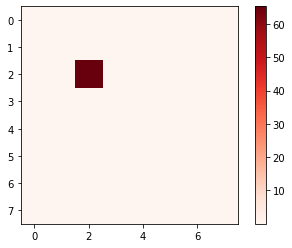

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds')
plt.colorbar();

In [4]:
#visibilities = np.fft.fft2(sky_image).astype('complex64')
#print(visibilities)

In [5]:
#modulus = np.absolute(visibilities)
#plt.imshow(modulus, cmap='Blues')
#plt.colorbar();

In [6]:
#sanity = np.fft.ifft2(visibilities).astype('complex64')

##test1_real = ((sky_image.real - sanity.real)**2).mean()
#test1_imag = ((sky_image.imag - sanity.imag)**2).mean()
 
#print('Reals MSE: '+ str(test1_real))
#print('Imaginaries MSE: '+ str(test1_imag))

In [7]:
def qpie_circuit(im): #for square image 2^n * 2^n

    n = int(np.log2(len(im)))

    vals = im.flatten()
    vals = vals/np.linalg.norm(vals) #normalize coefficients

    qc = QuantumCircuit(2*n)

    qc.initialize(vals)

    return qc

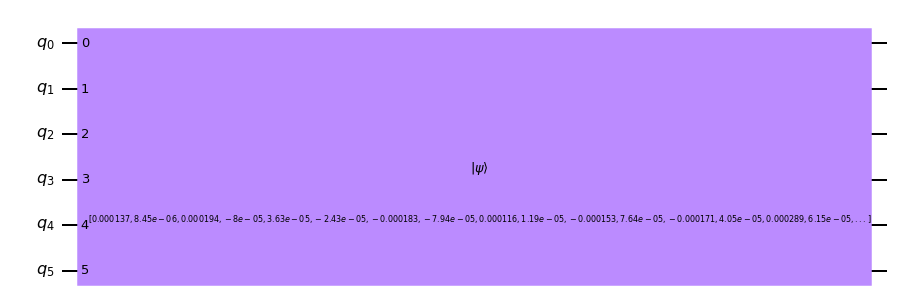

In [8]:
qc = qpie_circuit(sky_image)
qc.draw('mpl')

In [9]:
def decode_out(qc,norm,fourier=False,shots_mult=10):
    
    n = qc.num_qubits
    shots = shots_mult * 2**20 #number of shots desired

    backend = Aer.get_backend('qasm_simulator')
    results = execute(qc, backend=backend, shots=shots).result()
    answer = results.get_counts()

    outim = np.zeros((int(2**(n/2)), int(2**(n/2))))

    b = 0
    for i,j in np.ndindex(outim.shape):

        bit = format(b, '0' + str(n) + 'b')
        p_i = answer.get(bit,0)/shots
        
        if fourier:
            pix_val = np.sqrt(p_i) * norm * 2**(n/2)
        else:
            pix_val = np.sqrt(p_i) * norm
            
        outim[i,j] = (pix_val)

        b+=1
    
    return outim

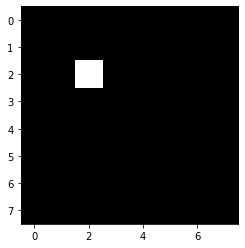

In [10]:
qc.measure_all() #we don't forget to add measurement

norm = (np.linalg.norm(sky_image.flatten()))
imout = decode_out(qc,norm)
plt.imshow(imout,cmap='gray')

In [11]:
def MSE(im1,im2):

    im = (im1-im2)**2
    s = np.sum(im.flatten())/(len(im1**2))

    return s

In [12]:
MSE(sky_image,imout)

0.0022050459323603813

In [13]:
n_n = n * n
inp = visibilities.flatten()
norm = np.linalg.norm(inp)
inp = inp / norm

#norm = qml.math.sum(qml.math.abs(inp) ** 2)
#normalized_data = inp / qml.math.sqrt(norm)

wires = range(math.ceil(math.log2(n_n)))
print( 'Wires: ' + str(wires) )
amp_dev = qml.device('default.qubit', wires)


@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires, normalize=False, pad_with=0.)
    wires1 = range( math.ceil(math.ceil(math.log2(n_n)) / 2) )
    wires2 = range( math.ceil(math.ceil(math.log2(n_n)) / 2), math.ceil(math.log2(n_n)))
    #qml.adjoint(qml.QFT)(wires=wires)
    #qml.adjoint(qml.QFT)(wires=wires2)
    return qml.state()

readout = amp_encoding(inp).astype('complex64')
#qml.draw_mpl(amp_encoding)(inp)

readout.numpy()
#readout = readout*qml.math.sqrt(norm)
readout = readout * norm
readout = readout[:(n_n)]
print(readout)
readout = np.array(readout).reshape(n , n)

NameError: name 'visibilities' is not defined

In [ ]:
#fidelity = readout
fidelity = np.fft.ifft2(readout).astype('complex64')

test2_real = ((sky_image.real - fidelity.real)**2).mean()
test2_imag = ((sky_image.imag - fidelity.imag)**2).mean()

print('Reals MSE: '+ str(test2_real))
print('Imaginaries MSE: '+ str(test2_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(fidelity)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')